# Wordle Experiment

In the game wordle, you are given six chances to guess a five letter word from the wordle dictionary. Each guess illuminates information about the letters in the word such as whether the letter is in the word: 'grey', the letter is in the word but not in the location given in your guess 'yellow' or whether the letter is in the word and in the right place: 'green'.

In this file we test two different wordle strategies, run the simulations and determine the expected number of guesses for each method.

In [1]:
import pandas as pd
from string import ascii_lowercase
import string
import numpy as np
import matplotlib.pyplot as plt
import random

Here is a list of all the 5 letter words from wordle.

In [2]:
#Read in all the 5 letter words from wordle.
dat=pd.read_csv('all_5_letter_words.csv')

words=dat['List of words'].values
for i in range(len(words)): #Iterate through string_list.
    words[i] = words[i].lower()

There are 2315 words in total.

In [3]:
len(words)

2315

Using the information we have about what the word might be, we have some prior knowledge about the distribution of these words such as the likelihoods that they contain 2 of the same letter, 3 of the same letter or 4 of the same letter

In [4]:
k=[]
for j in words:
    k.append(len(set(j)))

In [5]:
prob_4_same_letter=np.sum(np.array(k)==2)/len(k)
prob_3_same_letter=np.sum(np.array(k)==3)/len(k)
prob_2_same_letter=np.sum(np.array(k)==4)/len(k)
prob_all_different=np.sum(np.array(k)==5)/len(k)

To simulate wordle we first need to create a function that can give us outcomes of guesses given a word

In [7]:
def outcome_of_guess(actual_word, guess):
    outcome=[]
    for i in np.arange(0,5):
        letter=guess[i]
        
        if actual_word.count(letter)==0:
            outcome.append('o')
            
        if actual_word[i]==letter:
                outcome.append('g')
        
        if (actual_word[i]!=letter) & (actual_word.count(letter)>0):
                outcome.append('y')
    outcome=''.join(outcome)
    return outcome 

We can test this as follows. Suppose the actual word is: 'watch' and I guess 'carts'

In [8]:
outcome_of_guess('watch', 'carts')

'ygoyo'

We see that 'c' and 't' are the right letters but wrong location, 'a' is in the right location and 's' and 'r' are not in the word

# Strategies

We have two strategies with how we wish to play the game. In my strategy (strategy - Jen) we choose our next guess such that
1. It satisfies all criteria given from previous guesses.
2. If it is an incorrect guess it maximises the information we have for our next guess by choosing letters that are most likely to be in the word based on the word pool remaining after our previous guesses.
We continue this until we guess the word.

In the other strategy (strategy - Tom) we choose our next guess so that:
1. It maximises the information about the word by choosing letters that have not been chosen previously but are most likely to be in the word.

We continue this until we narrow down our search to <3 options, or until we have information about all the letters and then we guess sequentially through the remaining list.

# First guess

Both methods require the first guess to be the guess that contains the most likely letters to be in the word. We can compute this by searching the words in wordle for the most common letters.

In [29]:
#If it contains the letter then add one to the count
def find_prior(words):
    freq=[]
    for letter in ascii_lowercase:
        letter_use=0
        i=+1
        #print(words)
        for j in words:
            letter_use+=(j.count(letter)>0)
        final=letter_use
        freq.append(final)
    prior_prob=np.array(freq)/len(words)
    alphabet=list(string.ascii_lowercase)
    #Our first prior probabilty 
    d = {'letter':alphabet, 'prob1': prior_prob}
    df=pd.DataFrame(data=d)
    return df

<BarContainer object of 26 artists>

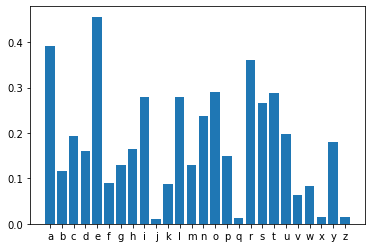

In [31]:
table=find_prior(words)
table.sort_values(by='prob1')
plt.bar(table['letter'],table['prob1'])

To compute my next guess I look at the probability that a letter is in the word, and weight all the words by adding their probabilities together. The higher the value of the weighted word, the better and more informative the guess.

In [32]:
def next_guess_jen(prior_prob,words):
    
    #prior prob = table of letters and probability of appearance based on the valid words
    #words = words remaining based on outcomes of previous guesses
    
    df=prior_prob
    next_guess=[]
    weighted_words=[]
    for j in words:
        ww=0
        for letter in j:
            ww+=df[df['letter']==letter]['prob1'].iloc[0]
        #Penalty for having multiple of the same letters
        if len(set(j))==2:
                ww=prob_2_same_letter*ww
        if len(set(j))==3:
                ww=prob_3_same_letter*ww
        if len(set(j))==4:
                ww=prob_2_same_letter*ww
        if len(set(j))==5:
                ww=prob_all_different*ww
        #weight all words using the weights of the letters
        weighted_words.append(ww)
    
    d = {'words': words, 'weight': weighted_words}
    new_df=pd.DataFrame(data=d)
    new_df=new_df.sort_values(by='weight',ascending=False)
    new_df=new_df.reset_index(drop=True)
    next_guess=new_df.words.iloc[0]
    return next_guess

In [33]:
#By this method my first guess is alert

next_guess_jen(table,words)

'alert'

Making a guess using Tom's method is similar except we weight the words in the full list based on what we know about the words remaining from our previous guesses. For the first guess the full list of words (words) is the same as the list of words remaining (valid_words) after getting information from previous guesses (since we have no previous guesses!).

In [ ]:
def next_guess_tom(prior_prob,words,valid_words):    
    #prior prob = table of letters and probability of appearance based on the valid words
    #words = full list of wordle words
    #valid_words = words remaining based on outcomes of previous guesses
    
    #If you know about 5 of the letter, or there is only one valid answer then guess that!
    if (len(valid_words)<3) | (np.sum(prior_prob['prob1']==1)==5):
        next_guess=valid_words[0]
    else:    
        df=prior_prob
        next_guess=[]
        weighted_words=[]
        #print(words)
        for j in words:
            ww=0
            for letter in j:
                #If we know the letter is in the word remove it's weighting - we don't 
                #want to guess this again since we already have information about this letter
                if df[df['letter']==letter]['prob1'].iloc[0]==1:
                    ww+=0
                #Else add the weighting based on the probability that the letter is in the word based on 
                #our remaining valid words
                else:
                    ww+=df[df['letter']==letter]['prob1'].iloc[0]
        #Penalty for having multiple of the same letters
            if len(set(j))==2:
                ww=prob_2_same_letter*ww
            if len(set(j))==3:
                    ww=prob_3_same_letter*ww
            if len(set(j))==4:
                    ww=prob_2_same_letter*ww
            if len(set(j))==5:
                    ww=prob_all_different*ww    
        #weight all words using the weights of the letters
            weighted_words.append(ww)
    
        d = {'words': words, 'weight': weighted_words}
        new_df=pd.DataFrame(data=d)
        new_df=new_df.sort_values(by='weight',ascending=False)
        new_df=new_df.reset_index(drop=True)

        next_guess=new_df.words.iloc[0]
    return next_guess

For the first guess we both guess the same word since our word list is the same for full list and the remaining list.

In [36]:
next_guess_tom(table,words,words)

'alert'

# Valid words

Next we update the valid word list based on our guess

In [21]:
def locations(string,s):
    lst= []
    for i in range(len(string)):
        if (string[i] == s):
            lst.append(i)
    return lst

def valid_words(outcome,first_guess,words):
    words_list=list(words)
    position_of_y=locations(outcome,'y')
    position_of_g=locations(outcome, 'g')
    position_of_o=locations(outcome, 'o')

    for j in words_list:
        if j==first_guess:
            words_list.remove(j)
            
    for i in position_of_y:
        letter=first_guess[i]
        updated_words=words_list.copy()
        for j in updated_words:
        #If it is not contained then remove it.
            if (j.count(letter)==0):
                words_list.remove(j)
            if j[i]==letter:
                words_list.remove(j)

    for i in position_of_g:
        letter=first_guess[i]
        updated_words=words_list.copy()
        for j in updated_words:
        #If letter is not at the correct spot then remove it.
            if (j[i]!=letter):
                words_list.remove(j)

    for i in position_of_o:
        letter=first_guess[i]
        updated_words=words_list.copy()
        for j in updated_words:
            #If it is not contained then remove it.
            if (j.count(letter)>0):
                words_list.remove(j)
    return words_list

For example the valid words after guessing 'shake' with outcome 'gggog' are as follows:

In [38]:
valid_words('gggog','shake', words)

['shade', 'shale', 'shame', 'shape', 'share', 'shave']

Using the following bits of code we can simulate wordle for a given word

In [44]:
def simulate_wordle(words,first_guess,print_result,actual_word):
       
    finish=0
    #actual_word=random.sample(list(words),1)[0]
    #actual_word='shade'
    if print_result == 'on':
        print('****ACTUAL WORD****')
        print(actual_word)
        
    guess=[first_guess]
    if print_result == 'on':
        print('****FIRST GUESS****')
        print(first_guess)
    outcome=outcome_of_guess(actual_word, first_guess)
    
    if print_result=='on':
        print('****OUTCOME*****')
        print(outcome)        
    
    words=list(valid_words(outcome,first_guess,words))
    
    if first_guess==actual_word:
        finish=1
        #Guessed it in one!
        
    i=0
    while finish==0:
        #Determine prior probability based on distribution of letters
        prior_prob=find_prior(words)
        next_guess=next_guess_jen(prior_prob,words)
        guess.append(next_guess)
        if print_result=='on':
            print('****GUESS*****')
            print(next_guess)
        i+=1
        outcome=outcome_of_guess(actual_word, next_guess)
        if print_result=='on':
            print('****OUTCOME*****')
            print(outcome)
        #print(outcome)
        #update state space
        words=list(valid_words(outcome,next_guess,words))
        if actual_word==next_guess:
            finish=1
    return i+1

In [40]:
def simulate_wordle_tom(words,first_guess,print_result,actual_word):
    
    words=list(words)
    finish=0
    #actual_word='shade'
    #random.sample(list(words),1)[0]
    if print_result == 'on':
        print('****ACTUAL WORD****')
        print(actual_word)
        
    guess=[first_guess]
    if print_result == 'on':
        print('****FIRST GUESS****')
        print(first_guess)
    outcome=outcome_of_guess(actual_word, first_guess)
    
    if print_result=='on':
        print('****OUTCOME*****')
        print(outcome)        
    
    #print(first_guess)
    v_words=list(valid_words(outcome,first_guess,words))
    words=list(new_words_tom(outcome,first_guess,words))
    #print(words)
    
    if first_guess==actual_word:
        finish=1
        #Guessed it in one!
    #print(words)
    i=0
    while finish==0:
        #Determine prior probability based on distribution of letters
        prior_prob=find_prior(v_words)
        next_guess=next_guess_tom(prior_prob,words,v_words)
        guess.append(next_guess)
        
        if print_result=='on':
            print('****GUESS*****')
            print(next_guess)
        i+=1
        
        outcome=outcome_of_guess(actual_word, next_guess)
        if print_result=='on':
            print('****OUTCOME*****')
            print(outcome)
        #print(outcome)
        #update state space
        #print('*****')
        #print(next_guess)
        v_words=list(valid_words(outcome,next_guess,v_words))
        if words.count(next_guess)>0:
            words.remove(next_guess)
        #words=list(new_words_tom(outcome,next_guess,words))
        #print(words)
        #words.remove(next_guess)
        if actual_word==next_guess:
            finish=1
    return i+1
    
def new_words_tom(outcome,first_guess,words):
    words.remove(first_guess)
    return words 

Let's test our methods on actual word 'remit'

In [41]:
simulate_wordle_tom(words, 'alert', 'on','remit')

****ACTUAL WORD****
remit
****FIRST GUESS****
alert
****OUTCOME*****
ooyyg
****GUESS*****
imbue
****OUTCOME*****
yyooy
****GUESS*****
merit
****OUTCOME*****
ygygg
****GUESS*****
remit
****OUTCOME*****
ggggg


4

In [48]:
simulate_wordle(words, 'alert', 'on','remit')

****ACTUAL WORD****
remit
****FIRST GUESS****
alert
****OUTCOME*****
ooyyg
****GUESS*****
merit
****OUTCOME*****
ygygg
****GUESS*****
remit
****OUTCOME*****
ggggg


3

This code is the same but removes the print for long runs

In [46]:
def simulate_wordle_no_print(words,first_guess,actual_word):
       
    finish=0
    #actual_word=random.sample(list(words),1)[0]
    #actual_word='shade'
        
    guess=[first_guess]
    outcome=outcome_of_guess(actual_word, first_guess)
        
    
    words=list(valid_words(outcome,first_guess,words))
    
    if first_guess==actual_word:
        finish=1
        #Guessed it in one!
        
    i=0
    while finish==0:
        #Determine prior probability based on distribution of letters
        prior_prob=find_prior(words)
        next_guess=next_guess_jen(prior_prob,words)
        guess.append(next_guess)
        i+=1
        outcome=outcome_of_guess(actual_word, next_guess)
        #print(outcome)
        #update state space
        words=list(valid_words(outcome,next_guess,words))
        if actual_word==next_guess:
            finish=1
    return i+1
    
    

def simulate_wordle_tom_no_print(words,first_guess,actual_word):
    
    words=list(words)
    finish=0
    #actual_word='shade'
    #random.sample(list(words),1)[0]

    guess=[first_guess]

    outcome=outcome_of_guess(actual_word, first_guess)
    
    
    #print(first_guess)
    v_words=list(valid_words(outcome,first_guess,words))
    words=list(new_words_tom(outcome,first_guess,words))
    #print(words)
    
    if first_guess==actual_word:
        finish=1
        #Guessed it in one!
    #print(words)
    i=0
    while finish==0:
        #Determine prior probability based on distribution of letters
        prior_prob=find_prior(v_words)
        next_guess=next_guess_tom(prior_prob,words,v_words)
        guess.append(next_guess)
        
        i+=1
        
        outcome=outcome_of_guess(actual_word, next_guess)
        v_words=list(valid_words(outcome,next_guess,v_words))
        if words.count(next_guess)>0:
            words.remove(next_guess)
        if actual_word==next_guess:
            finish=1
    return i+1

# Expected guesses

Now we are satisfied that the simulations are running as expected we can run on the entire wordspace to determine the expected number of guesses for both our methods!

In [145]:
#Run on all words
random_words=list(words)

In [146]:
number_of_guesses_tom2=[]
for i in np.arange(0,len(words)):
    number_of_guesses_tom2.append(simulate_wordle_tom_no_print(words, 'alert',random_words[i]))

In [147]:
number_of_guesses_jen2=[]
for i in np.arange(0,len(words)):
    number_of_guesses_jen2.append(simulate_wordle_no_print(words, 'alert',random_words[i]))

3.744276457883369
0.7273169317782889


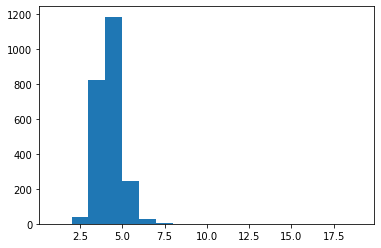

In [156]:
#TOMS METHOD
bins_list=np.arange(1,20)
plt.hist(number_of_guesses_tom2,bins=bins_list)
print(np.mean(number_of_guesses_tom2))
print(np.std(number_of_guesses_tom2))
number_of_guesses_tom2


d = {'words': random_words, 'guesses(tom)': number_of_guesses_tom2}
new_df=pd.DataFrame(data=d)

3.686393088552916
0.9169207041303054


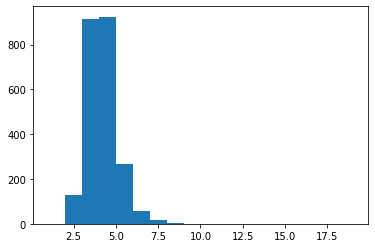

In [160]:
#JENS METHOD
bins_list=np.arange(1,20)
plt.hist(number_of_guesses_jen2,bins=bins_list)
print(np.mean(number_of_guesses_jen2))
print(np.std(number_of_guesses_jen2))
number_of_guesses_jen2


d = {'words': random_words, 'guesses(jen)': number_of_guesses_jen2}
new_df=pd.DataFrame(data=d)

Overall my method takes fewer guesses on average however, the standard deviation is higher than Tom's method!